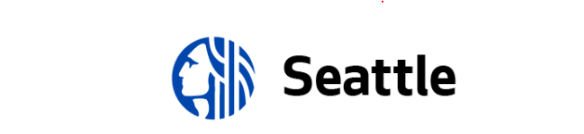

In [1]:
# add notebook summary
import jyquickhelper as jqh
from jyquickhelper import add_notebook_menu
add_notebook_menu(menu_id='OCDS_P4', raw=False, format='html',
                  header="Predict Buildings Energy Use - Modelisation of TotalGHGEmissions", first_level=1, last_level=5,
                  keep_item=None)

# 1 - Import librairies & packages

In [2]:
# data transformation
import numpy as np
import pandas as pd

# serialization
import pickle

# data pre-processing
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold, StratifiedKFold, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

# configure transformers to output pandas DataFrames
from sklearn import set_config
set_config(transform_output="pandas")

# maths & stats
import random

# visualisation
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import seaborn as sns

# dummy model
from sklearn.dummy import DummyRegressor

# linear regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# nearest-neighbors regression model
from sklearn.neighbors import KNeighborsRegressor

# support vector model
from sklearn.svm import SVR

# ensemble learning models
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb

# model performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from timeit import default_timer as timer

# feature importance analysis
import shap
# shap.initjs()

# set dataframe display options
pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)

# disable convergence warnings after checking
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# 2 - Load data

In [3]:
# initialise random state for all models and transformers
rs_list = [8, 13, 42]
rs = rs_list[random.randrange(len(rs_list))]
print("Random state =", rs)

Random state = 42


In [4]:
# load most highly correlated columns to use for iterative imputation of EnergyStarScore
with open('ess_max_corrs.pkl', 'rb') as f:
    ess_max_corrs = pickle.load(f)

n_features = len(ess_max_corrs)

    
print(n_features, "features are more strongly correlated to the Energy Star Score : ", ess_max_corrs)

4 features are more strongly correlated to the Energy Star Score :  ['NumberofFloors', 'PropertyGFABuilding(s)', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']


In [5]:
data_all = pd.read_csv('data_all_ter.csv')

In [6]:
data_all.head()

,OSEBuildingID,PrimaryPropertyType,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SiteEnergyUseWN(kBtu)_bins,TotalGHGEmissions_bins,UsesSteam,UsesElectricity,UsesGas,SteamUse_%,Electricity_%,NaturalGas_%,SiteEnergyUseWN(kBtu)_pred
0,1,Hotel,DOWNTOWN,47.61220,-122.33799,1.0,12,0,88434,60.0,7456910.0,249.98,89,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high,high,1,1,1,0.277302,0.546060,0.176638,2.379687e+06
1,2,Hotel,DOWNTOWN,47.61317,-122.33393,1.0,11,15064,88502,61.0,8664479.0,295.86,20,0.0,0.0,0.0,0.0,0.0,0.809918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high,high,0,1,1,0.000000,0.386609,0.613391,2.326427e+06
2,3,Hotel,DOWNTOWN,47.61393,-122.33810,1.0,41,196718,759392,43.0,73937112.0,2089.28,47,0.0,0.0,0.0,0.0,0.0,0.791220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high,high,1,1,1,0.297113,0.682307,0.020579,7.530149e+06
3,5,Hotel,DOWNTOWN,47.61412,-122.33664,1.0,10,0,61320,56.0,6946800.5,286.43,90,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high,high,1,1,1,0.325913,0.407519,0.266567,5.760175e+06
4,8,Hotel,DOWNTOWN,47.61375,-122.34047,1.0,18,62000,113580,75.0,14656503.0,505.01,36,0.0,0.0,0.0,0.0,0.0,0.703070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high,high,0,1,1,0.000000,0.378802,0.621198,5.058127e+05


In [7]:
data_all['OSEBuildingID'] = data_all['OSEBuildingID'].astype('category')
data_all['PrimaryPropertyType'] = data_all['PrimaryPropertyType'].astype('category')
data_all['Neighborhood'] = data_all['Neighborhood'].astype('category')
data_all['SiteEnergyUseWN(kBtu)_bins'] = data_all['SiteEnergyUseWN(kBtu)_bins'].astype('category')
data_all['TotalGHGEmissions_bins'] = data_all['TotalGHGEmissions_bins'].astype('category')
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383 entries, 0 to 1382
Data columns (total 46 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   OSEBuildingID                          1383 non-null   category
 1   PrimaryPropertyType                    1383 non-null   category
 2   Neighborhood                           1383 non-null   category
 3   Latitude                               1383 non-null   float64 
 4   Longitude                              1383 non-null   float64 
 5   NumberofBuildings                      1383 non-null   float64 
 6   NumberofFloors                         1383 non-null   int64   
 7   PropertyGFAParking                     1383 non-null   int64   
 8   PropertyGFABuilding(s)                 1383 non-null   int64   
 9   ENERGYSTARScore                        923 non-null    float64 
 10  SiteEnergyUseWN(kBtu)                  1383 non-null   float

# 3 - Prepare features & target variable

## 3.1 - Without EnergyStarScore

In [8]:
X_no_ess = data_all.drop(labels=['OSEBuildingID', 'PrimaryPropertyType', 'Neighborhood', 'ENERGYSTARScore',
                                 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)_bins', 
                                'UsesSteam', 'UsesElectricity', 'UsesGas'], axis=1).copy()
y_no_ess = data_all['TotalGHGEmissions']

In [9]:
print(X_no_ess.shape)
X_no_ess.head(1)

(1383, 36)


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,TotalGHGEmissions_bins,SteamUse_%,Electricity_%,NaturalGas_%,SiteEnergyUseWN(kBtu)_pred
0,47.6122,-122.33799,1.0,12,0,88434,89,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high,0.277302,0.54606,0.176638,2.379687e+06


## 3.2 - With EnergyStarScore

In [10]:
X_w_ess = data_all.drop(labels=['OSEBuildingID', 'PrimaryPropertyType', 'Neighborhood', 'SiteEnergyUseWN(kBtu)',
                                'TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)_bins', 'UsesSteam', 'UsesElectricity', 
                                'UsesGas'], axis=1).copy()
y_w_ess = data_all['TotalGHGEmissions']

In [11]:
print(X_w_ess.shape)
X_w_ess.head(1)

(1383, 37)


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,TotalGHGEmissions_bins,SteamUse_%,Electricity_%,NaturalGas_%,SiteEnergyUseWN(kBtu)_pred
0,47.6122,-122.33799,1.0,12,0,88434,60.0,89,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high,0.277302,0.54606,0.176638,2.379687e+06


# 4 - Split data into training and testing sets

## 4.1 - Without EnergyStarScore

In [12]:
# split into train (70%) and temp (30%) sets
X_train_no_ess_bins, X_temp_no_ess_bins, y_train_no_ess, y_temp_no_ess = train_test_split(X_no_ess, y_no_ess, test_size=0.3,
                                                                                random_state=rs, shuffle=True,
                                                                                stratify=X_no_ess['TotalGHGEmissions_bins'])

In [13]:
# further split temp set into testing and validation sets
X_test_no_ess_bins, X_val_no_ess_bins, y_test_no_ess, y_val_no_ess = train_test_split(X_temp_no_ess_bins, y_temp_no_ess,
                                                                                          test_size=0.5, random_state=rs,
                                                                                          shuffle=True, 
                                                                                          stratify=X_temp_no_ess_bins['TotalGHGEmissions_bins'])

In [14]:
X_train_no_ess = X_train_no_ess_bins.drop(labels=['TotalGHGEmissions_bins'], axis=1)
X_test_no_ess = X_test_no_ess_bins.drop(labels=['TotalGHGEmissions_bins'], axis=1)
X_val_no_ess = X_val_no_ess_bins.drop(labels=['TotalGHGEmissions_bins'], axis=1)

In [15]:
print(X_train_no_ess.shape)
X_train_no_ess.head(1)

(968, 35)


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%,SiteEnergyUseWN(kBtu)_pred
1203,47.59938,-122.33197,1.0,3,0,26000,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.771433,0.228567,875804.98985


In [16]:
print(X_test_no_ess.shape)
X_test_no_ess.head(1)

(207, 35)


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%,SiteEnergyUseWN(kBtu)_pred
1288,47.67816,-122.28998,1.0,1,0,29079,61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.593189,0.406811,3.343927e+06


In [17]:
print(X_val_no_ess.shape)
X_val_no_ess.head(1)

(208, 35)


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%,SiteEnergyUseWN(kBtu)_pred
1273,47.61469,-122.31596,1.0,2,0,61880,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.434226e+07


## 4.2 - With EnergyStarScore

In [18]:
# split into train (70%) and temp (30%) sets
X_train_w_ess_bins, X_temp_w_ess_bins, y_train_w_ess, y_temp_w_ess = train_test_split(X_w_ess, y_w_ess, test_size=0.3,
                                                                                random_state=rs, shuffle=True,
                                                                                stratify=X_w_ess['TotalGHGEmissions_bins'])

In [19]:
# further split temp set into testing and validation sets
X_test_w_ess_bins, X_val_w_ess_bins, y_test_w_ess, y_val_w_ess = train_test_split(X_temp_w_ess_bins, y_temp_w_ess, test_size=0.5,
                                                                                random_state=rs, shuffle=True,
                                                                                stratify=X_temp_w_ess_bins['TotalGHGEmissions_bins'])

In [20]:
X_train_w_ess = X_train_w_ess_bins.drop(labels=['TotalGHGEmissions_bins'], axis=1)
X_test_w_ess = X_test_w_ess_bins.drop(labels=['TotalGHGEmissions_bins'], axis=1)
X_val_w_ess = X_val_w_ess_bins.drop(labels=['TotalGHGEmissions_bins'], axis=1)

In [21]:
print(X_train_w_ess.shape)
X_train_w_ess.head(1)

(968, 36)


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%,SiteEnergyUseWN(kBtu)_pred
1203,47.59938,-122.33197,1.0,3,0,26000,NaN,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.771433,0.228567,875804.98985


In [22]:
print(X_test_w_ess.shape)
X_test_w_ess.head(1)

(207, 36)


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%,SiteEnergyUseWN(kBtu)_pred
1288,47.67816,-122.28998,1.0,1,0,29079,78.0,61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.593189,0.406811,3.343927e+06


In [23]:
print(X_val_w_ess.shape)
X_val_w_ess.head(1)

(208, 36)


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%,SiteEnergyUseWN(kBtu)_pred
1273,47.61469,-122.31596,1.0,2,0,61880,66.0,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.434226e+07


### 4.2.1 - Imputation on training set

In [24]:
# use iterative imputer to fill NaNs in EnergyStarScore column - set min to 0 and max to 100 as per methodology available at :
# https://www.energystar.gov/buildings/benchmark/understand-metrics/how-score-calculated
energy_star = IterativeImputer(missing_values=np.nan, max_iter=10, tol=0.001, n_nearest_features=n_features,
                                 initial_strategy='mean', imputation_order='ascending', min_value=1, max_value=100,
                                 skip_complete=False,  verbose=1, random_state=rs, add_indicator=False)

In [25]:
X_1 = X_train_w_ess.select_dtypes(include='number')
imputed_1 = energy_star.fit_transform(X_1)
X_train_w_ess_ii = pd.DataFrame(imputed_1, columns=X_1.columns).reset_index(drop=True)
X_2 = X_train_w_ess.select_dtypes(exclude='number').reset_index(drop=True)
X_train_w_ess_imputed = X_2.join(X_train_w_ess_ii)
X_train_w_ess_imputed['ENERGYSTARScore'] = round(X_train_w_ess_imputed['ENERGYSTARScore'],0).astype(int, errors='ignore')
print(X_train_w_ess_imputed.shape)
print(X_train_w_ess_imputed.isna().sum().sum(), 'nulls in result dataframe.')
X_train_w_ess_imputed.sample(5)

[IterativeImputer] Completing matrix with shape (968, 36)
[IterativeImputer] Change: 11.451816816339011, scaled tolerance: 241446.09347 
[IterativeImputer] Early stopping criterion reached.
(968, 36)
0 nulls in result dataframe.


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%,SiteEnergyUseWN(kBtu)_pred
244,47.61552,-122.31744,1.0,2.0,19928.0,55916.0,62,89.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.374993,0.375007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.924722,0.075278,7.874327e+06
702,47.69875,-122.36725,1.0,2.0,31000.0,3636.0,3,50.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.039381,0.0,0.0,0.0,0.0,0.0,0.293148,0.706852,1.172735e+07
611,47.60366,-122.33328,1.0,3.0,0.0,52298.0,89,95.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.960840,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,2.367570e+06
37,47.61118,-122.28800,1.0,1.0,0.0,21850.0,100,116.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.258205,0.741795,5.674731e+07
201,47.61952,-122.34462,1.0,3.0,0.0,51552.0,62,3.0,0.0,0.0,0.012609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.050396,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,8.909075e+06


### 4.2.2 - Imputation on testing set

In [26]:
X_3 = X_test_w_ess.select_dtypes(include='number')
imputed_3 = energy_star.transform(X_3)
X_test_w_ess_ii = pd.DataFrame(imputed_3, columns=X_3.columns).reset_index(drop=True)
X_4 = X_test_w_ess.select_dtypes(exclude='number').reset_index(drop=True)
X_test_w_ess_imputed = X_4.join(X_test_w_ess_ii)
X_test_w_ess_imputed['ENERGYSTARScore'] = round(X_test_w_ess_imputed['ENERGYSTARScore'],0).astype(int, errors='ignore')
print(X_test_w_ess_imputed.shape)
print(X_test_w_ess_imputed.isna().sum().sum(), 'nulls in result dataframe.')
X_test_w_ess_imputed.sample(5)

[IterativeImputer] Completing matrix with shape (207, 36)
(207, 36)
0 nulls in result dataframe.


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%,SiteEnergyUseWN(kBtu)_pred
5,47.72286,-122.34612,1.0,2.0,0.0,20088.0,61,37.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.174233,0.000000,0.0,0.0,0.0,0.000000,0.0,0.800478,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,8.755824e+05
10,47.56613,-122.33838,1.0,1.0,0.0,411584.0,43,30.0,0.0,0.0,0.0,0.699852,0.0,0.0,0.0,0.0,0.0,0.203319,0.000000,0.000000,0.0,0.0,0.0,0.086884,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.497091,0.502909,2.330526e+06
74,47.60967,-122.33229,1.0,36.0,0.0,794592.0,96,36.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.941377,0.012554,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.975339,0.024661,4.290667e+06
101,47.61087,-122.33339,1.0,34.0,146694.0,847518.0,63,34.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.144138,0.565999,0.289862,1.143736e+07
138,47.61391,-122.33725,1.0,20.0,32334.0,233517.0,90,47.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.851808,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.448898,0.551102,0.000000,9.233446e+05


### 4.2.3 - Imputation on validation set

In [27]:
X_5 = X_val_w_ess.select_dtypes(include='number')
imputed_5 = energy_star.transform(X_5)
X_val_w_ess_ii = pd.DataFrame(imputed_5, columns=X_5.columns).reset_index(drop=True)
X_6 = X_val_w_ess.select_dtypes(exclude='number').reset_index(drop=True)
X_val_w_ess_imputed = X_6.join(X_val_w_ess_ii)
X_val_w_ess_imputed['ENERGYSTARScore'] = round(X_val_w_ess_imputed['ENERGYSTARScore'],0).astype(int, errors='ignore')
print(X_val_w_ess_imputed.shape)
print(X_val_w_ess_imputed.isna().sum().sum(), 'nulls in result dataframe.')
X_val_w_ess_imputed.sample(5)

[IterativeImputer] Completing matrix with shape (208, 36)
(208, 36)
0 nulls in result dataframe.


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%,SiteEnergyUseWN(kBtu)_pred
177,47.55297,-122.32472,1.0,1.0,0.0,47105.0,61,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.962106,0.0,0.413675,0.586325,1.441888e+06
7,47.62298,-122.33082,1.0,2.0,0.0,27788.0,73,104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.173528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.175399,0.0,0.783074,0.216926,3.512246e+06
76,47.62231,-122.34145,1.0,2.0,0.0,28800.0,61,88.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.545594,0.454406,8.049625e+06
112,47.55436,-122.33631,1.0,1.0,0.0,46340.0,3,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.000000,4.961763e+06
129,47.65138,-122.35565,1.0,1.0,0.0,30730.0,61,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.628759,0.371241,1.875277e+06


# 5 - Preprocessing

## 5.1 - For Linear models, K-nearest Neighbors and Support Vector Regression

In [28]:
# avoid error message when running GridSearch with OneHotEncoder in Pipe
# Pandas output does not support sparse data. Set sparse_output=False to output pandas dataframes or disable Pandas output via
# ` ohe.set_output(transform="default")
set_config(transform_output="default")

In [29]:
# scale features and correct for skew
num_transfo_lin = Pipeline(steps=[('scaler', PowerTransformer(method='yeo-johnson', standardize=True, copy=True))])

### 5.1.1 - Without Energy Star Score

In [30]:
# split numerical and categorical columns for data without EnergyStarScore and list column names
num_X_no_ess = X_train_no_ess.select_dtypes(include='number').columns.tolist()
preproc_lin_no_ess = ColumnTransformer(transformers=[('num', num_transfo_lin, num_X_no_ess)])

### 5.1.2 - With Energy Star Score

In [31]:
# split numerical and categorical columns for data with EnergyStarScore and list column names
num_X_w_ess = X_train_w_ess_imputed.select_dtypes(include='number').columns.tolist()
preproc_lin_w_ess = ColumnTransformer(transformers=[('num', num_transfo_lin, num_X_w_ess)])

## 5.2 - For Ensemble Learning Models

**StandardScaler is not generally required with tree-based and other ensemble learning models, although it can in some very specific cases improve the performance of the model. As this is not the case here, this pre-precessing step has been removed from the pipeline.**

# 6 - Modelisation

## 6.1 - Without EnergyStarScore

In [35]:
# initialise models
models = [
    ('Linear Regression', LinearRegression(positive=True)),
    ('ElasticNet', ElasticNet(positive=True)),
    ('KNN', KNeighborsRegressor()),
    ('SVR', SVR(cache_size=2000)),
    ('Random Forest Regression', RandomForestRegressor()),
    ('Gradient Boosting Regression', GradientBoostingRegressor())            
]

# create list of ensemble models
ens_models = ['Random Forest Regression', 'Gradient Boosting Regression']

# define hyperparameter grids
param_grids = [
    # for Linear Regression
    {'model__fit_intercept': [True, False], 'model__copy_X' : [True]}, 
    # for ElasticNet Regression
    {'model__alpha' : [0.01, 0.1, 1], 'model__random_state': [rs], 'model__copy_X' : [True],
     'model__selection' : ['random'], 'model__tol' : [0.001], 'model__l1_ratio' : [0.1, 0.2, 0.5],
     'model__max_iter': [2000]},
    # for KNN Regression
    {'model__n_neighbors': [10, 15, 20], 'model__weights' : ['distance'],
    'model__algorithm' : ['ball_tree', 'kd_tree'], 'model__leaf_size' : [15, 30, 45], 'model__p' : [1, 2],
    'model__n_jobs' : [-1]}, 
    # for Support Vector Regression
    {'model__kernel' : ['rbf'], 'model__gamma' : [0.01, 0.1, 1],
     'model__C' : [0.01, 0.1, 1, 10, 100, 1000], 'model__epsilon' : [0.05, 0.01, 0.1], 'model__max_iter': [2000], 
    'model__tol' : [0.001]},
    # for Random Forest Regression
    {'model__n_estimators': [100, 200], 'model__random_state' : [rs], 'model__max_depth' : [5, 10],
     'model__bootstrap': [True, False], 'model__min_samples_leaf':[2, 3], 'model__min_samples_split':[2, 5], 
     'model__max_features' : ['sqrt', 'log2' ], 'model__max_leaf_nodes': [20, 50], 'model__n_jobs': [-1]}, 
    # for Gradient Boosting Regression
    {'model__learning_rate' : [0.5, 0.25, 0.1], 'model__n_estimators' : [200, 400], 'model__random_state' : [rs], 
    'model__loss' : ['squared_error'], 'model__max_features' : ['sqrt', 'log2' ], 'model__max_depth': [5, 10], 
     'model__subsample': [0.5, 0.75], 'model__min_samples_split': [2, 5]},
]

In [36]:
# fit models using GridSearchCV

# initialize empty list to store models evaluation metrics
model_metrics_no_ess = []

# iterate over models and respective parameter grid
for (name, model), param_grid in zip(models, param_grids):
    # create pipeline with relevant preprocessor and model
    if name in ens_models:
        pipe = Pipeline(steps=[('model', model)])
    else:
        pipe = Pipeline(steps=[('preprocessor', preproc_lin_no_ess), ('model', model)])
    
    # k_values = np.arange(2,11,1)
    # k_values = [5, 9, 10]
    k_values = [10] # on all fits, k=10 consistently gave the best model, so we limit iterations on k to save on fit time
    
    for k in k_values:
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=rs)
        spl = skf.split(X_train_no_ess, X_train_no_ess_bins['TotalGHGEmissions_bins'])
        
        # Perform GridSearchCV on the pipeline with the current hyperparameter grid   
        grid_search = GridSearchCV(pipe, param_grid, cv=spl, scoring='r2', refit=True, error_score='raise', verbose=False)
    
        # Fit the GridSearchCV object on the training data
        train_start = timer()
        grid_search.fit(X_train_no_ess, y_train_no_ess.values)
        train_end = timer()
        train_time = train_end - train_start
        
        # Get the best hyperparameters and best training score
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
         
        # evaluate model on validation set & get score
        val_start = timer()
        val_score = grid_search.score(X_val_no_ess, y_val_no_ess) # uses score defined by scoring or best_estimator_.score
        y_pred_no_ess = grid_search.predict(X_val_no_ess)
        val_end = timer()
        val_time = val_end - val_start
               
    # append results to results list
    model_metrics_no_ess.append({
        'Model': name,
        'Training set':'X_train_no_ess',
        'Best parameters': best_params,
        'Train R2': best_score,  
        'Train fit time': train_time,        
        'Val R2': val_score, 
        'Val MAE' : mean_absolute_error(y_val_no_ess, y_pred_no_ess),
        'Strat. K-Fold' : skf
    })


C:\Users\PC\anaconda3\envs\shap_env\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\PC\anaconda3\envs\shap_env\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\PC\anaconda3\envs\shap_env\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\PC\anaconda3\envs\shap_env\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [37]:
# store model metrics & coefs in dataframes
model_no_ess_compare = pd.DataFrame(model_metrics_no_ess)

# display dataframe
model_no_ess_compare

,Model,Training set,Best parameters,Train R2,Train fit time,Val R2,Val MAE,Strat. K-Fold
0,Linear Regression,X_train_no_ess,"{'model__copy_X': True, 'model__fit_intercept': True}",-0.631969,2.455257,-0.146523,183.641979,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
1,ElasticNet,X_train_no_ess,"{'model__alpha': 1, 'model__copy_X': True, 'model__l1_ratio': 0.1, 'model__max_iter': 2000, 'model__random_state': 42, 'model__selection': 'random', 'model__tol': 0.001}",0.041578,9.900708,0.176808,142.249337,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
2,KNN,X_train_no_ess,"{'model__algorithm': 'ball_tree', 'model__leaf_size': 15, 'model__n_jobs': -1, 'model__n_neighbors': 20, 'model__p': 1, 'model__weights': 'distance'}",0.098023,47.322293,0.322436,88.879122,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
3,SVR,X_train_no_ess,"{'model__C': 1000, 'model__epsilon': 0.01, 'model__gamma': 0.1, 'model__kernel': 'rbf', 'model__max_iter': 2000, 'model__tol': 0.001}",0.329047,88.002521,0.442992,80.946064,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
4,Random Forest Regression,X_train_no_ess,"{'model__bootstrap': True, 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__max_leaf_nodes': 50, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200, 'model__n_jobs': -1, 'model__random_state': 42}",0.326903,293.990584,0.673156,80.142692,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
5,Gradient Boosting Regression,X_train_no_ess,"{'model__learning_rate': 0.1, 'model__loss': 'squared_error', 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_split': 5, 'model__n_estimators': 400, 'model__random_state': 42, 'model__subsample': 0.5}",0.330717,390.901233,0.611290,88.728073,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"


In [38]:
# export dataframes to file
model_no_ess_compare.to_csv('GHGE_model_no_ess_compare.csv', index=False)

## 6.2 - With EnergyStarScore

In [39]:
# fit models using GridSearchCV

# initialize empty list to store model evaluation metrics
model_metrics_w_ess = []


# iterate over models and respective parameter grid
for (name, model), param_grid in zip(models, param_grids):
    # crete pipeline with relevant preprocessor and model
    if name in ens_models:
        pipe = Pipeline(steps=[('model', model)])
    else:
        pipe = Pipeline(steps=[('preprocessor', preproc_lin_w_ess), ('model', model)])
    
    # k_values = np.arange(2,11,1)
    # k_values = [5, 9, 10]
    k_values = [10] # on all fits, k=10 consistently gave the best model, so we limit iterations on k to save on fit time
    
    for k in k_values:
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=rs)
        spl = skf.split(X_train_w_ess, X_train_w_ess_bins['TotalGHGEmissions_bins'])
        
        # Perform GridSearchCV on the pipeline with the current hyperparameter grid
        grid_search = GridSearchCV(pipe, param_grid, cv=spl, scoring='r2', refit=True, error_score='raise', verbose=False)
    
        # Fit the GridSearchCV object on the training data
        train_start = timer()
        grid_search.fit(X_train_w_ess_imputed, y_train_w_ess.values)
        train_end = timer()
        train_time = train_end - train_start
        
        # get best hyperparameters & best training score
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
           
        # evaluate model on validation set & get score
        val_start = timer()
        val_score = grid_search.score(X_val_w_ess_imputed, y_val_w_ess)
        y_pred_w_ess = grid_search.predict(X_val_w_ess_imputed)
        val_end = timer()
        val_time = val_end - val_start
         
    # append results to results list
    model_metrics_w_ess.append({
        'Model': name,
        'Training set':'X_train_w_ess',
        'Best parameters': best_params,
        'Train R2': best_score, 
        'Train fit time': train_time,        
        'Val R2': val_score, 
        'Val MAE' : mean_absolute_error(y_val_w_ess, y_pred_w_ess),
        'Strat. K-Fold' : skf
    })

C:\Users\PC\anaconda3\envs\shap_env\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\PC\anaconda3\envs\shap_env\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [40]:
# store model metrics in dataframe
model_w_ess_compare = pd.DataFrame(model_metrics_w_ess)

# display dataframe
model_w_ess_compare

,Model,Training set,Best parameters,Train R2,Train fit time,Val R2,Val MAE,Strat. K-Fold
0,Linear Regression,X_train_w_ess,"{'model__copy_X': True, 'model__fit_intercept': True}",-0.631969,2.156501,-0.146523,183.641979,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
1,ElasticNet,X_train_w_ess,"{'model__alpha': 1, 'model__copy_X': True, 'model__l1_ratio': 0.1, 'model__max_iter': 2000, 'model__random_state': 42, 'model__selection': 'random', 'model__tol': 0.001}",0.041579,9.053661,0.176810,142.250171,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
2,KNN,X_train_w_ess,"{'model__algorithm': 'ball_tree', 'model__leaf_size': 15, 'model__n_jobs': -1, 'model__n_neighbors': 20, 'model__p': 1, 'model__weights': 'distance'}",0.228457,46.662040,0.316137,88.949666,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
3,SVR,X_train_w_ess,"{'model__C': 1000, 'model__epsilon': 0.1, 'model__gamma': 0.1, 'model__kernel': 'rbf', 'model__max_iter': 2000, 'model__tol': 0.001}",0.333713,91.508390,0.430051,82.173927,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
4,Random Forest Regression,X_train_w_ess,"{'model__bootstrap': True, 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__max_leaf_nodes': 50, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200, 'model__n_jobs': -1, 'model__random_state': 42}",0.361527,293.763676,0.657860,80.099848,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
5,Gradient Boosting Regression,X_train_w_ess,"{'model__learning_rate': 0.25, 'model__loss': 'squared_error', 'model__max_depth': 5, 'model__max_features': 'log2', 'model__min_samples_split': 2, 'model__n_estimators': 400, 'model__random_state': 42, 'model__subsample': 0.75}",0.304669,418.690173,0.584950,84.362604,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"


In [41]:
# export dataframe to file
model_w_ess_compare.to_csv('GHGE_model_w_ess_compare.csv', index=False)

## 6.3 - Best model choice & evaluation

### 6.3.1 - Determine best model based on validation set results

In [42]:
# find best model & best features set
best_model_no_ess = model_no_ess_compare.loc[model_no_ess_compare['Val R2'] == model_no_ess_compare['Val R2'].max()]
best_model_w_ess = model_w_ess_compare.loc[model_w_ess_compare['Val R2'] == model_w_ess_compare['Val R2'].max()]
best_models = pd.concat([best_model_no_ess, best_model_w_ess])
best_models

,Model,Training set,Best parameters,Train R2,Train fit time,Val R2,Val MAE,Strat. K-Fold
4,Random Forest Regression,X_train_no_ess,"{'model__bootstrap': True, 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__max_leaf_nodes': 50, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200, 'model__n_jobs': -1, 'model__random_state': 42}",0.326903,293.990584,0.673156,80.142692,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
4,Random Forest Regression,X_train_w_ess,"{'model__bootstrap': True, 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__max_leaf_nodes': 50, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200, 'model__n_jobs': -1, 'model__random_state': 42}",0.361527,293.763676,0.657860,80.099848,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"


**The inclusion of the Energy Star Score in the input features only slightly improves the training R2 whilst slightly degrading the validation R2. We will therefore leave it out of the features for the final model.**

In [43]:
# find best model & best features set
best_model = best_models.loc[best_models['Val R2'] == best_models['Val R2'].max()
                                               ]['Model']
i = best_model.index[0]
print('Best model :\n', best_model)
best_features = best_models.loc[best_models['Val R2'] == best_models['Val R2'].max()
                                               ]['Training set'][i]
print('Best features :\n', best_features)
best_params = best_models.loc[best_models['Val R2'] == best_models['Val R2'].max()
                                           ]['Best parameters'][i]
print('Best parameters :\n', best_params)

Best model :
 4    Random Forest Regression
Name: Model, dtype: object
Best features :
 X_train_no_ess
Best parameters :
 {'model__bootstrap': True, 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__max_leaf_nodes': 50, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200, 'model__n_jobs': -1, 'model__random_state': 42}


In [44]:
# import parameters from modelisation results
final_params = {
    key.replace('model__', ''): value
    for key, value in best_params.items()
    if isinstance(key, str)
}

final_params

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': 50,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42}

### 6.3.2 - Retrain model on entire dataset (train + val)

#### 6.3.2.1 - Without Energy Star Score

**- Create new training set from original training set and validation set :**

In [45]:
X_train = pd.concat([X_train_no_ess, X_val_no_ess])
print(X_train.shape)
X_train.sample(5)

(1176, 35)


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%,SiteEnergyUseWN(kBtu)_pred
1099,47.57298,-122.33644,1.0,1,0,51050,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.969638,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.652525,0.347475,8.991462e+06
992,47.56680,-122.32149,1.0,1,0,25520,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.987461,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.357182,0.642818,7.525174e+06
1319,47.60427,-122.32311,1.0,8,0,178000,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.022079,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.583646,0.416354,0.000000,1.016347e+06
277,47.63549,-122.34103,1.0,3,12998,53464,64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,1.083326,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.000000,2.683827e+06
914,47.59949,-122.31851,1.0,2,0,29631,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.43873,0.000000,0.0,0.0,0.0,0.000000,0.168742,0.0,0.0,0.0,0.0,0.539975,0.0,0.0,0.000000,0.532085,0.467915,1.730311e+06


In [46]:
y_train = pd.concat([y_train_no_ess, y_val_no_ess])
print(y_train.shape)
y_train.sample(5)

(1176,)


1348    6330.91
259      726.96
344       65.30
714       36.74
762       44.89
Name: TotalGHGEmissions, dtype: float64

In [47]:
X_test = X_test_no_ess
print(X_test.shape)
X_test.sample(5)

(207, 35)


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%,SiteEnergyUseWN(kBtu)_pred
1341,47.66246,-122.29898,1.0,6,239252,65773,3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.06527,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.045770,0.0,0.475023,0.524977,2.692669e+06
1213,47.59971,-122.33065,1.0,5,0,41920,110,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.000000,2.993252e+06
1266,47.68750,-122.35496,1.0,1,14570,12806,12,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.467782,0.0,0.617340,0.382660,4.597359e+07
1251,47.53104,-122.32784,1.0,1,0,24024,39,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.595821,0.0,0.0,0.0,0.0,0.404179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.000000,1.616025e+06
1239,47.60745,-122.32542,1.0,4,0,27800,104,0.0,0.0,0.0,0.0,0.0,0.0,0.399029,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.447306,0.552694,3.752833e+06


In [48]:
y_test = y_test_no_ess
print(y_test.shape)
y_test.sample(5)

(207,)


83      104.26
713     176.79
379     445.62
1243     19.61
389     692.12
Name: TotalGHGEmissions, dtype: float64

**- Apply same pre-processing step as in ensemble learning models pipeline:**
**- Train model on training + validation set using best hyperparameters and evaluate performance on testing set:**

In [49]:
final_model = RandomForestRegressor(**final_params)
final_pipe = Pipeline(steps=[('model', final_model)])

In [50]:
final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)
print('Test R2 : ', r2_score(y_test, y_pred))
print('\nTest MAE :', mean_absolute_error(y_test, y_pred))

Test R2 :  0.616578137948801

Test MAE : 80.6621654214539


In [51]:
y_train_pred = final_pipe.predict(X_train)
y_pred_no_ess = pd.DataFrame(np.concatenate((y_train_pred, y_pred), axis=0), columns=['TotalGHGEmissions_pred_no_ess'])

#### 6.3.2.2 - With Energy Star Score

**This data will be used for graphical representation purposes only.**

In [52]:
final_params_ess = {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 50, 'min_samples_leaf': 3,
                    'min_samples_split': 2, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 42}	

In [53]:
X_train_ess = pd.concat([X_train_w_ess_imputed, X_val_w_ess_imputed])
X_test_ess = X_test_w_ess_imputed
y_train_ess = y_train
y_test_ess = y_test_w_ess

In [54]:
final_model_ess = RandomForestRegressor(**final_params_ess)
final_pipe_ess = Pipeline(steps=[('model', final_model_ess)])

In [55]:
final_pipe_ess.fit(X_train_ess, y_train_ess)
y_pred_ess = final_pipe_ess.predict(X_test_ess)
print('Test R2 : ', r2_score(y_test_ess, y_pred_ess))
print('\nTest MAE :', mean_absolute_error(y_test_ess, y_pred_ess))

Test R2 :  0.564081965122757

Test MAE : 85.8597941163304


In [56]:
y_train_pred_ess = final_pipe_ess.predict(X_train_ess)
y_pred_ess = pd.DataFrame(np.concatenate((y_train_pred_ess, y_pred_ess), axis=0), columns=['TotalGHGEmissions_pred_w_ess'])

### 6.4.4 - Graph true vs. predicted values

In [57]:
y = data_all[['TotalGHGEmissions']]
scatter_data = pd.DataFrame(np.concatenate((y, y_pred_no_ess, y_pred_ess), axis=1), 
                            columns=['TotalGHGEmissions', 'TotalGHGEmissions_pred_no_ess', 'TotalGHGEmissions_pred_w_ess']).reset_index()

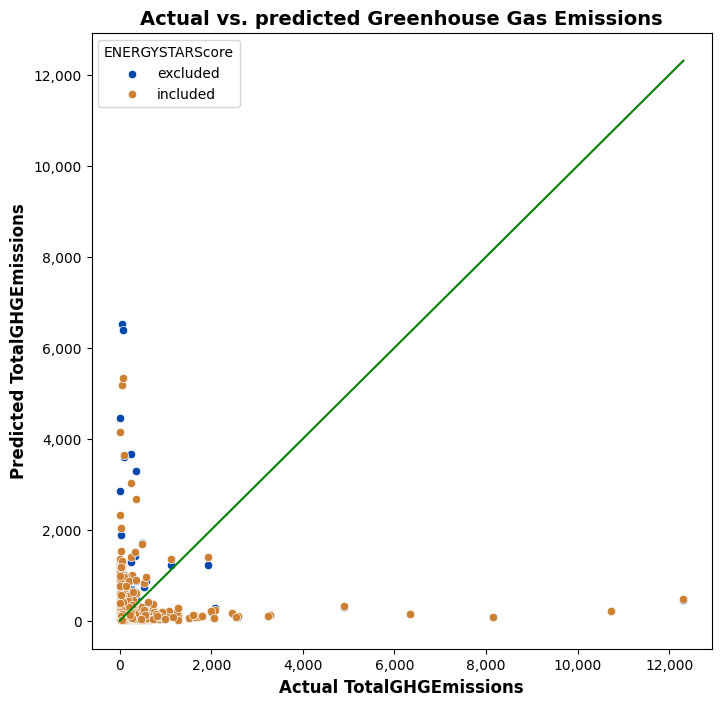

In [58]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=scatter_data['TotalGHGEmissions'], y=scatter_data['TotalGHGEmissions_pred_no_ess'], color='#0046AD')
sns.scatterplot(x=scatter_data['TotalGHGEmissions'], y=scatter_data['TotalGHGEmissions_pred_w_ess'], color='#CD7F32')
plt.legend(title='ENERGYSTARScore', loc='upper left', labels=['excluded', 'included'])
sns.lineplot(x=scatter_data['TotalGHGEmissions'], y=scatter_data['TotalGHGEmissions'], color='green')
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.title("Actual vs. predicted Greenhouse Gas Emissions", fontsize=14, fontweight='bold')
plt.xlabel("Actual TotalGHGEmissions", fontsize=12, fontweight='bold')
plt.ylabel("Predicted TotalGHGEmissions", fontsize=12, fontweight='bold')
plt.savefig('TotalGHGEmissions_ActuVsPred.png')
plt.show()

# 7 - Feature importance analysis

## 7.1 - Global feature importance

In [59]:
shap_values = shap.TreeExplainer(final_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.savefig('GHGE_shap_global_bars.png', bbox_inches='tight')
plt.close()

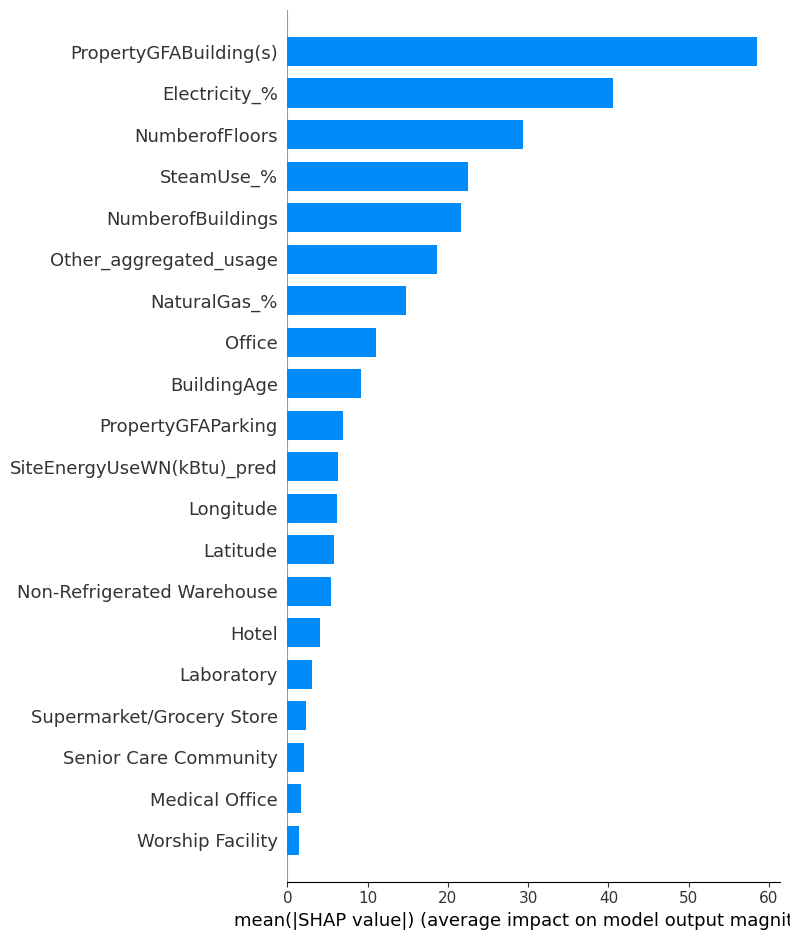

In [60]:
shap.decision_plot(shap.TreeExplainer(final_model).expected_value, shap_values, features = X_train.columns, show=False)
plt.savefig('GHGE_shap_global_decision.png', bbox_inches='tight')
plt.close()

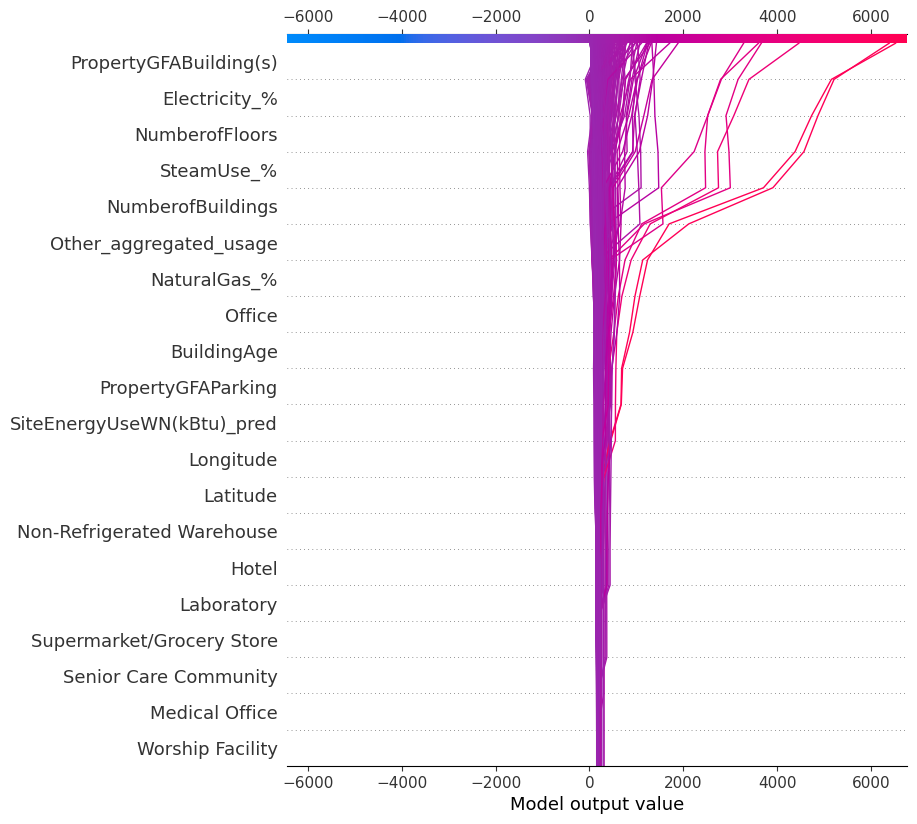

In [61]:
shap.summary_plot(shap_values, X_train, show=False)
plt.savefig('GHGE_shap_global_plot.png', bbox_inches='tight')
plt.close()

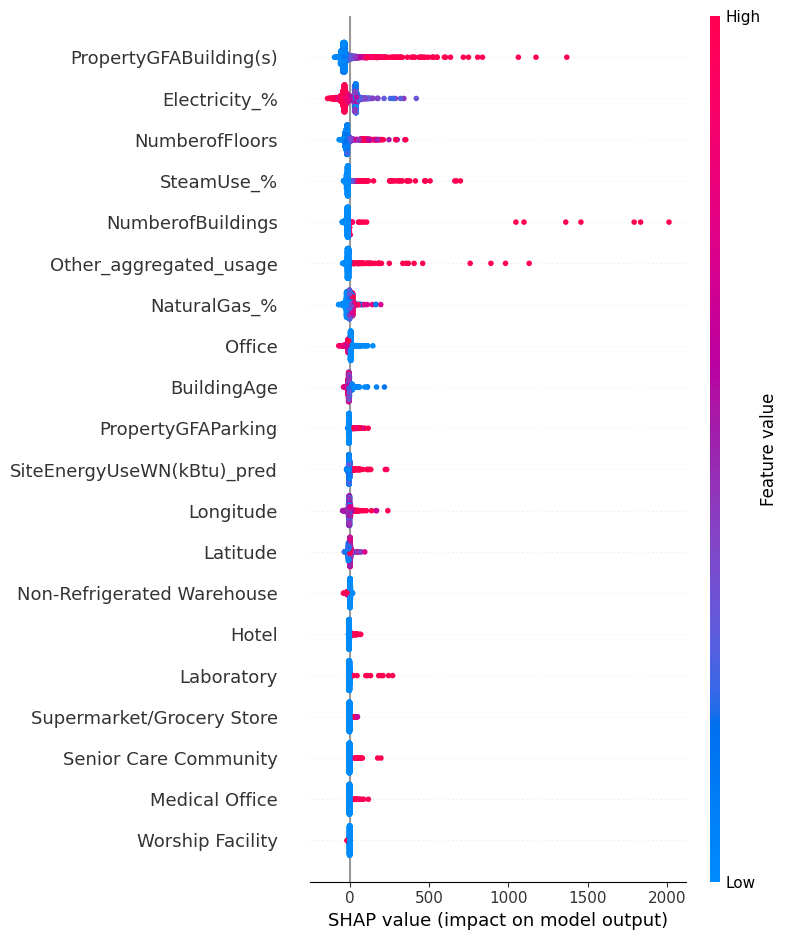

In [62]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train)
shap.plots.beeswarm(shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=X_train), show=False)
plt.savefig('GHGE_shap_swarm.png', bbox_inches='tight')
plt.close()

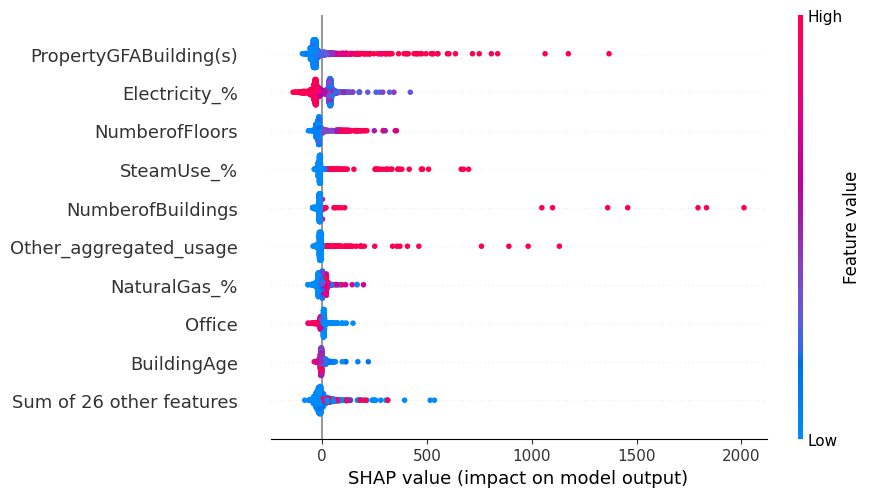

## 7.2 - Local feature importance

In [63]:
bat_num = 42
shap.force_plot(shap.TreeExplainer(final_model).expected_value, shap_values[bat_num], X_train.iloc[bat_num,:], show=False, 
                matplotlib=True, text_rotation=15)
plt.savefig('GHGE_shap_local_1.png', bbox_inches='tight')
plt.close()

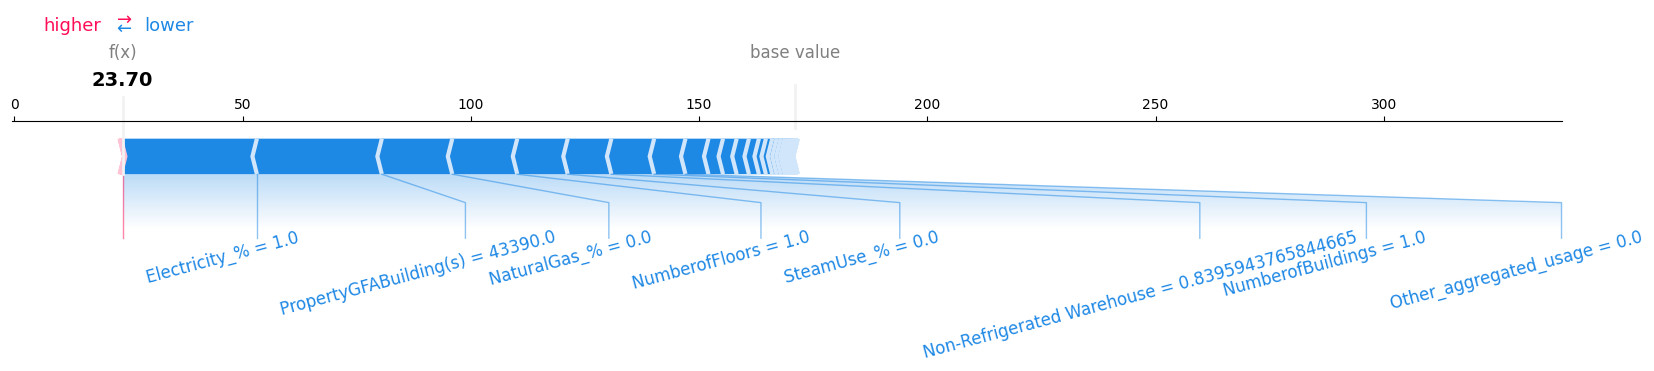

In [64]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train)
shap_value_i = shap_values[bat_num]
expected_value = explainer.expected_value
shap.plots.waterfall(shap.Explanation(values=shap_value_i, base_values=expected_value, data=X_train.iloc[bat_num]), show=False)
plt.savefig('GHGE_shap_local_2.png', bbox_inches='tight')
plt.close()

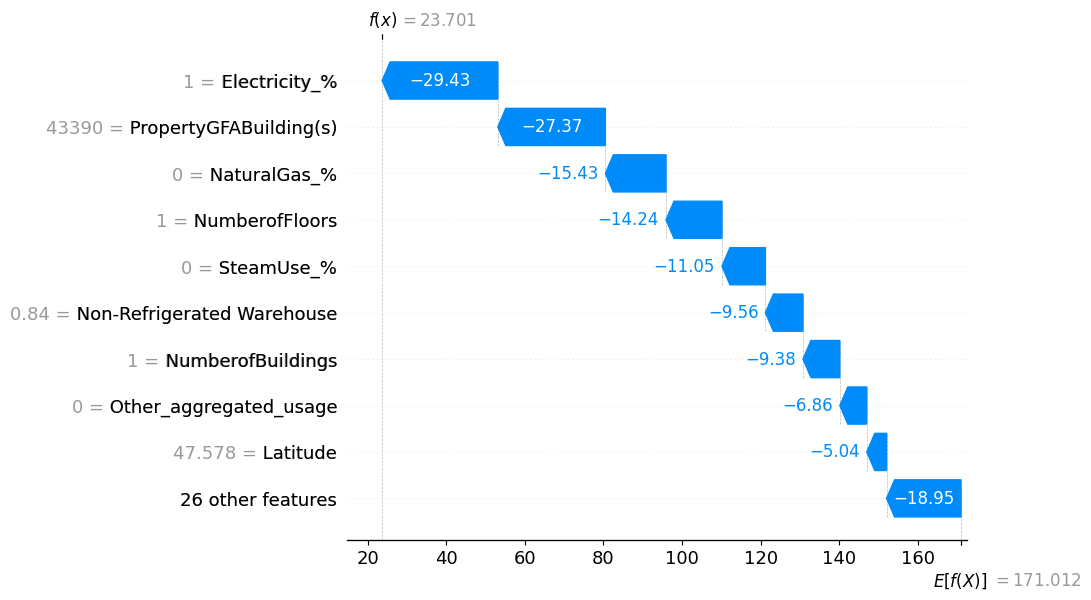